# Using Pauli Frame Update

In [43]:
from qiskit import __version__
print(__version__)

1.4.2


In [44]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, Pauli
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.controlflow import IfElseOp
from qiskit.circuit.library import XGate, ZGate
import matplotlib.pyplot as plt

In [180]:
import importlib
import steane_ec_decoder1
importlib.reload(steane_ec_decoder1)
from steane_ec_decoder1 import lookup

# Function for Encoding

In [182]:
def encoding(qc: QuantumCircuit):
    """
    theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
    amp_0 = np.cos(theta/2)
    amp_1 = np.sin(theta/2)
    qc.initialize([amp_0, amp_1], 0)
    for i in range(7):
        qc.id(i)
    for i in range(4, 7):
        qc.h(i)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(6, 0)
    qc.cx(6, 1)
    qc.cx(5, 0)
    qc.cx(6, 3)
    qc.cx(5, 2)
    qc.cx(4, 1)
    qc.cx(5, 3)
    qc.cx(4, 2)
    qc.cx(4, 3)
    """

# Functions for Stabilizer Extraction

In [183]:
def flag1(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister):
    # Setting first ancilla to |+>
    qc.h(first_qubit+7)
    
    qc.cx(first_qubit+7, first_qubit+3)
    qc.cx(first_qubit+2, first_qubit+9)
    qc.cx(first_qubit+5, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit)
    qc.cx(first_qubit+3, first_qubit+9)
    qc.cx(first_qubit+4, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+1)
    qc.cx(first_qubit+6, first_qubit+9)
    qc.cx(first_qubit+2, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+2)
    qc.cx(first_qubit+5, first_qubit+9)
    qc.cx(first_qubit+1, first_qubit+8)
    
    # Measure first ancilla in X-basis
    qc.h(first_qubit+7)
    
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9], c1)

In [184]:
def unflag(qc: QuantumCircuit, first_qubit: int, c2: ClassicalRegister):
    qc.h(first_qubit+7)
    qc.h(first_qubit+11)
    qc.h(first_qubit+12)
    
    qc.cx(first_qubit+7, first_qubit+3)
    qc.cx(first_qubit+2, first_qubit+9)
    qc.cx(first_qubit+5, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit)
    qc.cx(first_qubit+3, first_qubit+9)
    qc.cx(first_qubit+4, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+1)
    qc.cx(first_qubit+6, first_qubit+9)
    qc.cx(first_qubit+2, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+2)
    qc.cx(first_qubit+5, first_qubit+9)
    qc.cx(first_qubit+1, first_qubit+8)
    
    qc.cx(first_qubit+3, first_qubit+10)
    qc.cx(first_qubit+12, first_qubit+2)
    qc.cx(first_qubit+11, first_qubit+5)
    qc.cx(first_qubit, first_qubit+10)
    qc.cx(first_qubit+12, first_qubit+3)
    qc.cx(first_qubit+11, first_qubit+4)
    qc.cx(first_qubit+1, first_qubit+10)
    qc.cx(first_qubit+12, first_qubit+6)
    qc.cx(first_qubit+11, first_qubit+2)
    qc.cx(first_qubit+2, first_qubit+10)
    qc.cx(first_qubit+12, first_qubit+5)
    qc.cx(first_qubit+11, first_qubit+1)
    
    
    qc.h(first_qubit+7)
    qc.h(first_qubit+11)
    qc.h(first_qubit+12)
    
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12], c2)


In [185]:
def flag2(qc: QuantumCircuit, first_qubit: int, c3: ClassicalRegister):
    # Setting last two ancillas to |+>
    qc.h(first_qubit+8)
    qc.h(first_qubit+9)
    
    qc.cx(first_qubit+3, first_qubit+7)
    qc.cx(first_qubit+9, first_qubit+2)
    qc.cx(first_qubit+8, first_qubit+5)
    qc.cx(first_qubit+8, first_qubit+7)
    qc.cx(first_qubit, first_qubit+7)
    qc.cx(first_qubit+9, first_qubit+3)
    qc.cx(first_qubit+8, first_qubit+4)
    qc.cx(first_qubit+1, first_qubit+7)
    qc.cx(first_qubit+9, first_qubit+6)
    qc.cx(first_qubit+8, first_qubit+2)
    qc.cx(first_qubit+9, first_qubit+7)
    qc.cx(first_qubit+2, first_qubit+7)
    qc.cx(first_qubit+9, first_qubit+5)
    qc.cx(first_qubit+8, first_qubit+1)
    
    # Measrue last two ancillas in the X-basis
    qc.h(first_qubit+8)
    qc.h(first_qubit+9)
    
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9], c3)

# Function for QEC

In [203]:
def QEC(qc: QuantumCircuit, c1: ClassicalRegister, c2: ClassicalRegister, c3: ClassicalRegister):
    # Measuring flag1 circuit
    flag1(qc, 0, c1)
    qc.reset([7,8,9])
    
    # Path 1, flag1 measures 000
    path1 = QuantumCircuit(13)
    path1.add_register(c1, c2, c3)
    flag2(path1, 0, c3)
    path1.reset([7,8,9])
    # Path 2, flag1 measures anything but 000
    path2 = QuantumCircuit(13)
    path2.add_register(c1, c2, c3)
    unflag(path2, 0, c2)
    path2.reset([7,8,9,10,11,12])
    
    # Inside Path 1, Path 3: if flag2 measures 000
    path3 = QuantumCircuit(13)
    path3.add_register(c1, c2, c3)
    path3.reset([7,8,9,10,11,12])
    # Inside Path 1, Path 4: if flag2 measures anything but 000
    path4 = QuantumCircuit(13)
    path4.add_register(c1, c2, c3)
    unflag(path4, 0, c2)
    path4.reset([7,8,9,10,11,12])
    
    # Nested if
    nested_if = IfElseOp((c3, 0), true_body=path3, false_body=path4)
    # Add nested if to path1
    path1.append(nested_if, list(range(13)), c1[:] + c2[:] + c3[:])
    # First if
    first_if = IfElseOp((c1, 0), true_body=path1, false_body=path2)
    
    qc.append(first_if, list(range(13)), c1[:] + c2[:] + c3[:])

# Encoding + 1 Round of EC 

In [199]:
noise_model = NoiseModel()
"""
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [7]) 
noise_model.add_readout_error(readout_err, [8])
noise_model.add_readout_error(readout_err, [9])
noise_model.add_readout_error(readout_err, [10])
noise_model.add_readout_error(readout_err, [11])
noise_model.add_readout_error(readout_err, [12])
"""

"\nnoise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])\nnoise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['h'])\nnoise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])\n\n# 5% chance of flipping 0 <-> 1\nreadout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)\n                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)\n\n# Apply to all qubits being measured\nnoise_model.add_readout_error(readout_err, [7]) \nnoise_model.add_readout_error(readout_err, [8])\nnoise_model.add_readout_error(readout_err, [9])\nnoise_model.add_readout_error(readout_err, [10])\nnoise_model.add_readout_error(readout_err, [11])\nnoise_model.add_readout_error(readout_err, [12])\n"

In [230]:
qc = QuantumCircuit(13)
# Classical Register for flag1 measurements
c1 = ClassicalRegister(3, "c1")
# Classical Register for unflag measurements 
c2 = ClassicalRegister(6, "c2")
# Classical Register for flag2 measurements
c3 = ClassicalRegister(3, "c3")
qc.add_register(c1, c2, c3)

encoding(qc)

QEC(qc, c1, c2, c3)

qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

backend = AerSimulator(noise_model=noise_model)
transpiled = transpile(qc, backend, optimization_level=0)
job = backend.run(transpiled, shots=1, memory=True)
result = job.result()
memory = result.get_memory()

print(result)
print(memory)

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='890486a8-1a7e-4cda-9ffd-a34be7b8e6da', success=True, results=[ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x79': 1}, memory=['0x79'], statevector_post={'0x79': [Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))]}), header=QobjExperimentHeader(creg_sizes=[['c1', 3], ['c2', 6], ['c3', 3]], global_phase=1.5707963267948966, memory_slots=12, n_qubits=13, name='circuit-1584', qreg_sizes=[['q', 13]], metadata={}), status=DONE, seed_simulator=1804674223, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'device': 'CPU', 'time_taken': 0.009375412, 'measure_sampling': False, 'num_clbits'

In [231]:
from collections import defaultdict

hex_to_sv = []
hex_mem = result.data()['memory']

seen = defaultdict(int)
for mem in hex_mem:
    idx = seen[mem]
    val = result.data()['statevector_post'][mem][idx]
    hex_to_sv.append({mem:val})
    seen[mem] += 1
    
print(hex_to_sv)

[{'0x79': Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))}]


In [232]:
for i, dict in enumerate(hex_to_sv):
    bitstr_13, sv13 = next(iter(dict.items()))
    print(bitstr_13)
    print(sv13)

0x79
Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [233]:
sv_correction = []
for i, result in enumerate(hex_to_sv):
    str13, sv13 = next(iter(result.items()))
    cz, cx = lookup(memory[i])
    cz = cz + "I"*6
    cx = cx + "I"*6
    Pauli_cz = Pauli(cz)
    Pauli_cx = Pauli(cx)
    U_cz = Operator(Pauli_cz)
    U_cx = Operator(Pauli_cx)
    sv13 = sv13.evolve(U_cz)
    sv13 = sv13.evolve(U_cx)
    sv_correction.append(sv13)
print(sv_correction)

[Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))]


In [234]:
example = sv_correction[0]
red_sv = partial_trace(example, [7, 8, 9, 10, 11, 12])
display(red_sv.draw("latex"))

<IPython.core.display.Latex object>

In [229]:
test = QuantumCircuit(7)
encoding(test)
test = DensityMatrix(test)
display(test.draw("latex"))

<IPython.core.display.Latex object>

In [227]:
np.isclose(red_sv, test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [ ]:
print(red_sv == test)

False


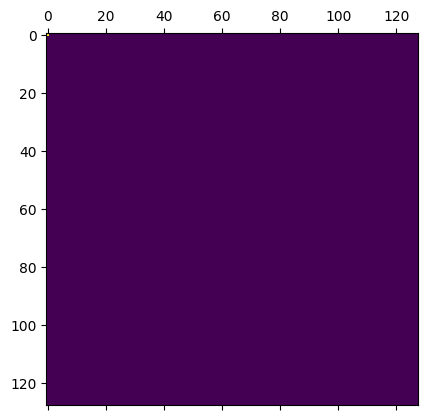

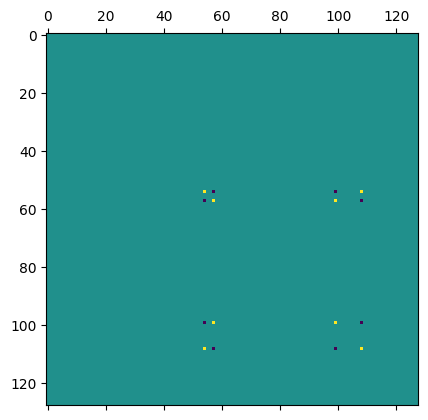

In [235]:
plt.matshow(test.data.real)
plt.matshow(red_sv.data.real)